In [1]:
import os 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from timezonefinder import TimezoneFinder
from geopy.geocoders import Nominatim
import time
import pytz

# User settings
Specify the list of countries, using names used in the SPLAT Energy Supply model 

In [2]:
countries = ['Angola', 'Botswana', 'DemocraticRepublicoftheCongo', 'Eswatini', 'Lesotho',
             'Malawi', 'Mozambique', 'Namibia', 'SouthAfrica', 'UnitedRepublicofTanzania', 'Zambia',
             'Zimbabwe']

# Load data
When saving the data in your `input` folder, we recommend to do the following:
- filter the excel to the countries of interest to you to reduce size
- save the data as `.csv` instead of `.xlsx` to improve performance when loading the data

For each country, clusters with the best resources for wind and solar have been identified. They are included in the data, with their corresponding latitude, longitude, theoretical capacity (MW), corresponding LCOE (taking into consideration resource quality but also distance to load and grid), and hourly profile for the year 2018.
To obtain hourly profiles for other years, the whole open-source code should be rerun. Refer to their [Github repo](https://github.com/SPLATteam/Model-Supply-Regions-MSR-Toolset/tree/main) and to the [article](https://www.nature.com/articles/s41597-022-01786-5) for more information.

To download the data, use this [Zenodo repository](https://zenodo.org/records/7014609). You should download the `.rar` file called `20220412_country_maps.rar`, and then extract it. To extract `.rar` files, you can use The Unarchiver if you are working on a Mac, or 7-Zip if you are working on Windows. On Linux, use a terminal-based tool like unrar or 7z.

In [3]:
file_solarMSR = os.path.join('input', 'SolarPV_BestMSRsToCover5%CountryArea.csv')
if not os.path.exists(file_solarMSR):
    raise FileNotFoundError(f"The file {file_solarMSR} does not exist. Please download the Solar PV MSR data and place it in the input folder.")
else:
    print(f"File {file_solarMSR} found. Proceeding with the analysis.")

File input/SolarPV_BestMSRsToCover5%CountryArea.csv found. Proceeding with the analysis.


In [4]:
file_windMSR = os.path.join('input', 'Wind_BestMSRsToCover5%CountryArea.csv')
if not os.path.exists(file_windMSR):
    raise FileNotFoundError(f"The file {file_windMSR} does not exist. Please download the Solar PV MSR data and place it in the input folder.")
else:
    print(f"File {file_windMSR} found. Proceeding with the analysis.")

File input/Wind_BestMSRsToCover5%CountryArea.csv found. Proceeding with the analysis.


# Process data
Extract average LCOE, CF, and hourly profiles for each country.
The code saves hourly profiles in the correct format to be used in the representative days analysis.

In [5]:
# Preprocess step to get country time zone. This step is necessary as IRENA data is expressed in local time. To account for a common time reference, those times need to be transformed into UTC time. To do so, each country time zone must be obtained

# Warning: this step may take a few dozen seconds

def extract_time_zone(countries, name_map):
    """
    Extracts the time zone (IANA tz database name, e.g., 'Africa/Luanda') for each country in a given list.

    This function takes a list of country names used in SPLAT (which may use non-standard naming conventions)
    and a mapping (`name_map`) from SPLAT-style names to standard country names (as recognized by geocoding services).
    It uses the `geopy` package to geocode each standard country name and `timezonefinder` to identify the time zone
    at the country centroid.

    Parameters:
    ----------
    countries : list of str
        List of SPLAT-style country names (e.g., ['SouthAfrica', 'DemocraticRepublicoftheCongo']).

    name_map : dict
        Dictionary mapping SPLAT-style names to standard country names 
        (e.g., {'SouthAfrica': 'South Africa'}).

    Returns:
    -------
    dict
        Dictionary mapping original SPLAT-style names to their IANA timezone name
        (e.g., {'SouthAfrica': 'Africa/Johannesburg'}).
    """
    standard_names = [name_map.get(c, c) for c in countries]

    # Initialize timezone and geolocation tools
    tf = TimezoneFinder()
    geolocator = Nominatim(user_agent="splat_timezones")
    
    # Build timezone dictionary
    country_timezones = {}
    
    for name, std_name in zip(countries, standard_names):
        try:
            location = geolocator.geocode(std_name, timeout=10)
            if location:
                tz = tf.timezone_at(lat=location.latitude, lng=location.longitude)
                country_timezones[name] = tz
            else:
                print(f"Could not geocode: {std_name}")
        except Exception as e:
            print(f"Error with {std_name}: {e}")
        
        time.sleep(1)  # avoid overloading the API
    return country_timezones

# Manual correction to standard names (to help geocoder or pycountry). Transform names used in the IRENA / SPLAT database into official country names.
# You only need to specify countries for which the SPLAT name does not correspond to official country name
name_map = {
    'SouthAfrica': 'South Africa',
    'DemocraticRepublicoftheCongo': 'Democratic Republic of the Congo',
    'UnitedRepublicofTanzania': 'Tanzania',
    # The others are fine
}

country_timezones = extract_time_zone(countries, name_map)

In [6]:
country_timezones

{'Angola': 'Africa/Luanda',
 'Botswana': 'Africa/Gaborone',
 'DemocraticRepublicoftheCongo': 'Africa/Lubumbashi',
 'Eswatini': 'Africa/Mbabane',
 'Lesotho': 'Africa/Maseru',
 'Malawi': 'Africa/Blantyre',
 'Mozambique': 'Africa/Maputo',
 'Namibia': 'Africa/Windhoek',
 'SouthAfrica': 'Africa/Johannesburg',
 'UnitedRepublicofTanzania': 'Africa/Dar_es_Salaam',
 'Zambia': 'Africa/Lusaka',
 'Zimbabwe': 'Africa/Harare'}

In [7]:
# We define capex parameters used in their model
# They use a discount rate of 10%, and lifetime of 25 years for generation, 40 years for transmission
CAPEX_PARAMETERS = {
    'solar': {
        'supply_asset_capital_recovery': 0.1101681,
        'operating_costs': 4,
        'fixed_costs': 53500
    },
    'wind': {
        'supply_asset_capital_recovery': 0.1101681,
        'operating_costs': 0,
        'fixed_costs': 64200
    },
    'grid': {
        'supply_asset_capital_recovery': 0.102259,
    },
    'road': {
        'supply_asset_capital_recovery': 0.11017,
    }
}

def compute_weighted_stats(group, tech):
    """Weighted statistics across all relevant clusters for a given country. We use the theoretical available capacity in a given cluster as the weight."""
    avg_cf = (group[column_cf] * group['CapacityMW']).sum() / group['CapacityMW'].sum()  # MWh / MW
    avg_lcoe = (group['LCOE-MWh'] * group['CapacityMW']).sum() / group['CapacityMW'].sum()  # $ / MWh
    # For the LCOE, we use the breakdown of the LCOE into different components (generation, road and transmission), and the capital recovery rates used in the MSR model
    cost_per_MW = ((((group['sLCOE-MWh'] - CAPEX_PARAMETERS[tech]['operating_costs'])  * (8760 * group[column_cf] / 100) - CAPEX_PARAMETERS[tech]['fixed_costs']) / CAPEX_PARAMETERS[tech]['supply_asset_capital_recovery'] + (group['tLCOE-MWh']  * (8760 * group[column_cf] / 100)) / CAPEX_PARAMETERS['grid']['supply_asset_capital_recovery'] + (group['rLCOE-MWh']  * (8760 * group[column_cf] / 100)) / CAPEX_PARAMETERS['road']['supply_asset_capital_recovery'])  * group['CapacityMW']).sum() / group['CapacityMW'].sum()  * 1e-6  # costs in m$ / MW
    
    return pd.Series({
        'avg_CF': avg_cf,
        'avg_LCOE': avg_lcoe,
        'cost_per_MW': cost_per_MW
    })


# Weighted hourly profile for each country
def weighted_hourly_profile(group):
    weights = group['CapacityMW'].values.reshape(-1, 1)
    hourly_data = group[hourly_cols].values
    weighted_avg = (hourly_data * weights).sum(axis=0) / weights.sum()
    return pd.Series(weighted_avg, index=hourly_cols)

def convert_to_utc(row, country_timezones):
    """
    Converts a local timestamp to UTC based on the country's time zone.

    This function is designed to be used within a pandas `.apply()` call
    to convert a 'timestamp' column (assumed local time) into UTC, using
    a dictionary that maps each country name to its IANA time zone string.

    Parameters
    ----------
    row : pd.Series
        A row from the DataFrame containing at least 'CtryName' and 'timestamp'.
    country_timezones : dict
        Dictionary mapping country names (as in 'CtryName') to their IANA time zone names,
        e.g., {'SouthAfrica': 'Africa/Johannesburg'}.

    Returns
    -------
    datetime
        The timestamp converted to UTC timezone.
    """
    ctry = row['CtryName']
    local_zone = pytz.timezone(country_timezones[ctry])
    local_time = local_zone.localize(row['timestamp'], is_dst=None)
    return local_time.astimezone(pytz.utc)



In [8]:
cf_lcoe_stats = {}
hourly_profiles = {}

for tech in ['wind', 'solar']:
    if tech == 'wind':
        file = file_windMSR 
        column_cf = 'CF100m'
    else:
        file = file_solarMSR
        column_cf = 'CF'

    # Select relevant columns
    meta_cols = ['CtryName', 'CapacityMW', column_cf, 'sLCOE-MWh', 'tLCOE-MWh', 'rLCOE-MWh', 'LCOE-MWh']
    hourly_cols = [f'H{i}' for i in range(1, 8761)]  # if needed

    # Combine what you need
    use_columns = meta_cols + hourly_cols  # or just meta_cols to start
    
    data_MSR_stats = pd.read_csv(file, usecols=use_columns, header=0)
    data_MSR_stats = data_MSR_stats[data_MSR_stats['CtryName'].isin([c for c in countries])]
    
    cf_lcoe_stats[tech] = data_MSR_stats.groupby('CtryName').apply(compute_weighted_stats, tech=tech).reset_index()
    
    data_MSR_hourlyprofile = data_MSR_stats.set_index(['CtryName', 'CapacityMW'])[hourly_cols].reset_index()
    hourly_profiles[tech] = data_MSR_hourlyprofile.groupby('CtryName').apply(weighted_hourly_profile).reset_index()
    
    # Saving data in good format for representative days analysis
    date_index = pd.date_range(start='2023-01-01', periods=8760, freq='H')  # 2023 is a non-leap year

    df_long = hourly_profiles[tech].melt(id_vars='CtryName', var_name='Hour', value_name='value')
    
    # Convert 'H1', ..., 'H8760' to integer hour index
    df_long['hour_index'] = df_long['Hour'].str.extract('H(\d+)').astype(int) - 1  # zero-based index
    
    df_long['timestamp'] = df_long['hour_index'].map(lambda i: date_index[i])
    
    # Convert local time to UTC
    df_long['CtryName'] = df_long['CtryName'].astype(str)  # just in case
    df_long['timestamp_utc'] = df_long.apply(lambda row: convert_to_utc(row, country_timezones), axis=1)

    # Create season, day and hours
    df_long['season'] = df_long['timestamp_utc'].dt.month
    df_long['day'] = df_long['timestamp_utc'].dt.day
    df_long['hour'] = df_long['timestamp_utc'].dt.hour
    
    # Step 5: Rename and index
    df_long = df_long.rename(columns={'CtryName': 'zone'})
    df_final = df_long.set_index(['zone', 'season', 'day', 'hour'])['value']
    df_final = df_final.to_frame().rename(columns={'value': 2018}).sort_values(by=['season', 'day', 'hour'])
    
    df_final.to_csv(os.path.join('output', f'data_SAPP_{tech}.csv'), index=True)

<>:33: SyntaxWarning: invalid escape sequence '\d'
<>:33: SyntaxWarning: invalid escape sequence '\d'
/var/folders/q1/q3sbpxn50b5frhgsdn1cq0z80000gn/T/ipykernel_51722/2098987490.py:33: SyntaxWarning: invalid escape sequence '\d'
  df_long['hour_index'] = df_long['Hour'].str.extract('H(\d+)').astype(int) - 1  # zero-based index
/var/folders/q1/q3sbpxn50b5frhgsdn1cq0z80000gn/T/ipykernel_51722/2098987490.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  cf_lcoe_stats[tech] = data_MSR_stats.groupby('CtryName').apply(compute_weighted_stats, tech=tech).reset_index()
/var/folders/q1/q3sbpxn50b5frhgsdn1cq0z80000gn/T/ipykernel_51722/2098987490.py:25: DeprecationWarning: DataFrameGroupBy.apply operated 

In [44]:
cf_lcoe_stats['wind']

,CtryName,avg_CF,avg_LCOE,cost_per_MW
0,Angola,32.976099,109.617762,2.312977
1,Botswana,39.880349,80.107799,1.961817
2,DemocraticRepublicoftheCongo,36.508983,88.663103,1.995822
3,Eswatini,33.874060,93.236770,1.922174
4,Lesotho,40.028991,78.797015,1.922185
5,Malawi,42.038923,75.140615,1.910601
6,Mozambique,33.194610,97.692880,1.983171
7,Namibia,39.932201,79.865951,1.948844
8,SouthAfrica,43.059433,71.631375,1.870003
9,UnitedRepublicofTanzania,44.505941,71.323400,1.920579


# Plots

In [45]:
tech = 'solar'

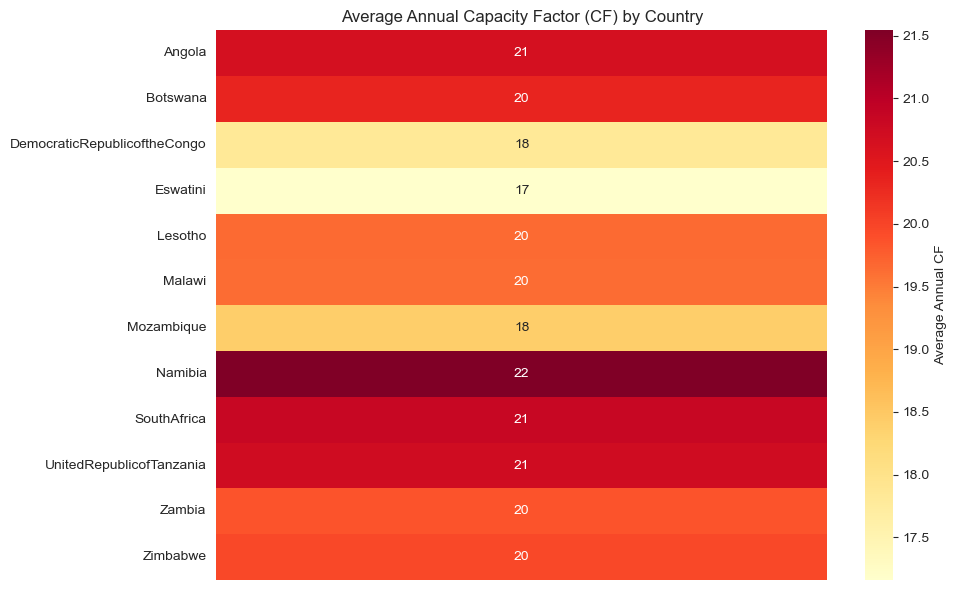

In [46]:
# Heatmap: average annual CF by country
cf_lcoe_stats_pivot = cf_lcoe_stats[tech].set_index('CtryName')[['avg_CF']]

plt.figure(figsize=(10, 6))
sns.heatmap(cf_lcoe_stats_pivot, annot=True, cmap='YlOrRd', cbar_kws={'label': 'Average Annual CF'})
plt.title('Average Annual Capacity Factor (CF) by Country')
plt.ylabel('')
plt.xlabel('')
plt.xticks([])
plt.tight_layout()
plt.show()

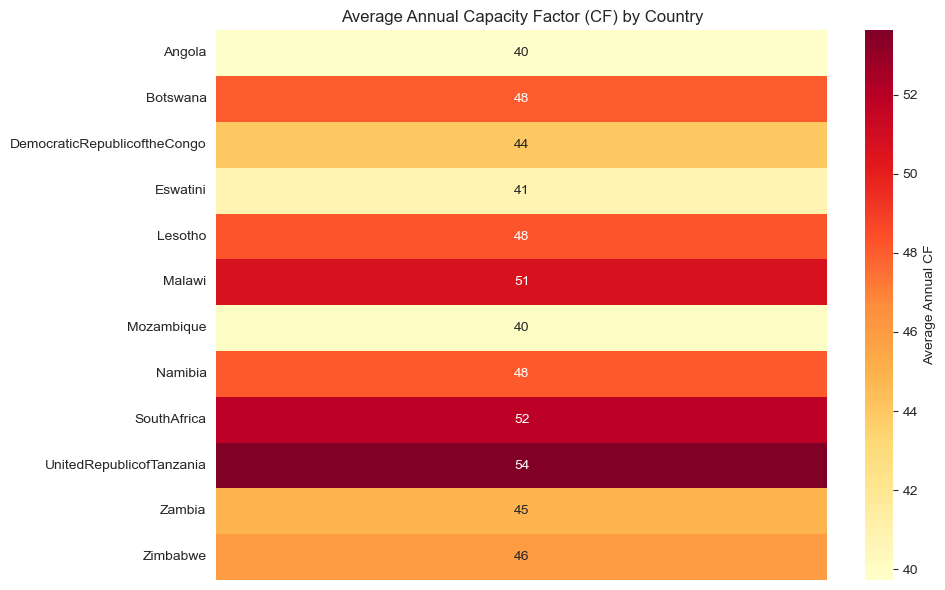

In [62]:
# Heatmap: average annual CF by country, from average statistics obtained from the hourly profile
df_hourly = pd.read_csv(os.path.join('output', f'data_SAPP_{tech}.csv'))
df_hourly = df_hourly.rename(columns={'2018': 'value'})
cf_lcoe_stats_pivot = df_hourly.groupby(['zone'])['value'].mean()
cf_lcoe_stats_pivot *= 100
cf_lcoe_stats_pivot = cf_lcoe_stats_pivot.to_frame()

plt.figure(figsize=(10, 6))
sns.heatmap(cf_lcoe_stats_pivot, annot=True, cmap='YlOrRd', cbar_kws={'label': 'Average Annual CF'})
plt.title('Average Annual Capacity Factor (CF) by Country')
plt.ylabel('')
plt.xlabel('')
plt.xticks([])
plt.tight_layout()
plt.show()

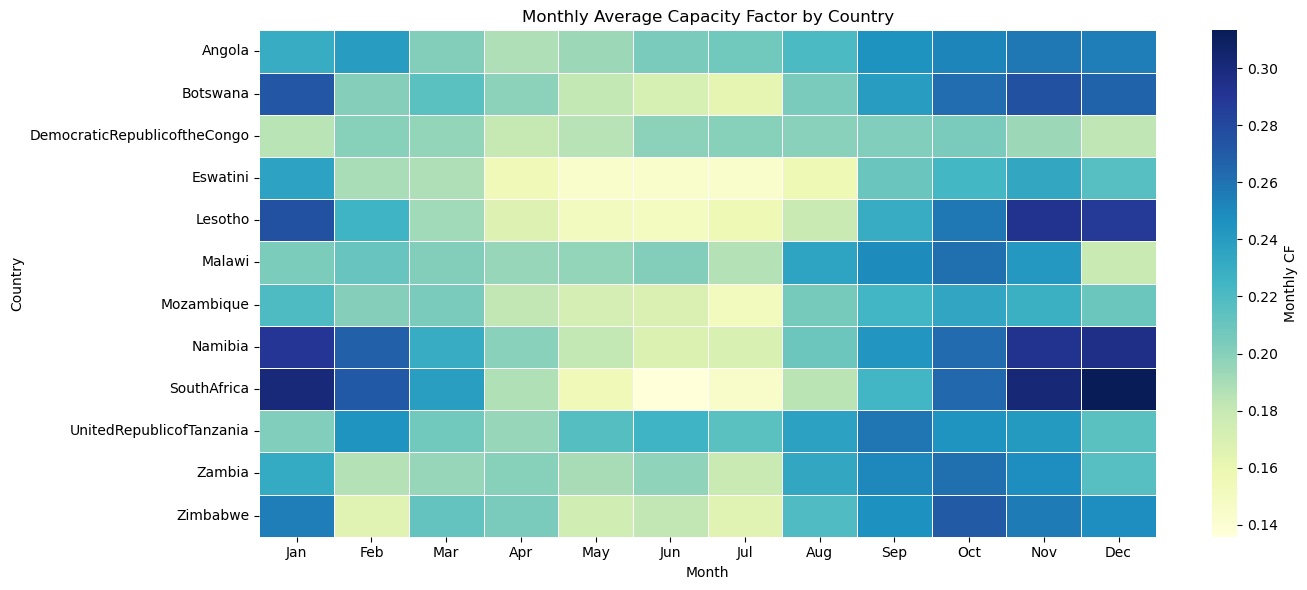

In [58]:
# Function to approximate monthly CF from 8760-hour profile
def approximate_monthly_cf(hourly_row):
    hours_per_month = [744, 672, 744, 720, 744, 720, 744, 744, 720, 744, 720, 744]  # hours/month
    monthly_cf = []
    cursor = 0
    for h in hours_per_month:
        monthly_cf.append(hourly_row[cursor:cursor+h].mean())
        cursor += h
    return monthly_cf

# Build monthly CF dataframe from hourly_profiles
monthly_cf_dict = {}
for _, row in hourly_profiles[tech].iterrows():
    country = row['CtryName']
    hourly_values = row.drop('CtryName').astype(float).values
    monthly_cf_dict[country] = approximate_monthly_cf(hourly_values)

monthly_cf_df = pd.DataFrame.from_dict(monthly_cf_dict, orient='index',
                                       columns=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                                                'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

# Plot heatmap
plt.figure(figsize=(14, 6))
sns.heatmap(monthly_cf_df, cmap='YlGnBu', linewidths=0.5, cbar_kws={'label': 'Monthly CF'})
plt.title('Monthly Average Capacity Factor by Country')
plt.ylabel('Country')
plt.xlabel('Month')
plt.tight_layout()
plt.show()


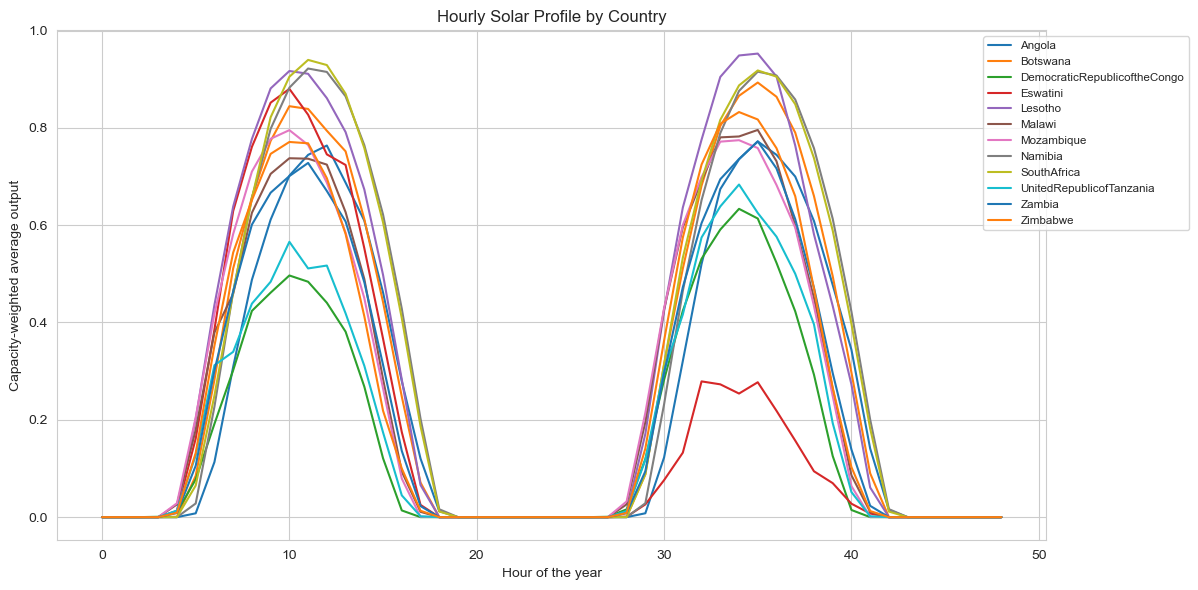

In [38]:
def plot_hourly_profiles(df_long, tech, hour_start=0, hour_end=8759):
    """
    Plots the hourly generation profile for each zone (country) from a long-format DataFrame
    with ['zone', 'season', 'day', 'hour', 'value'] columns. Selects a slice of hours using
    the overall hour-of-year index.

    Parameters
    ----------
    df_long : pd.DataFrame
        DataFrame in long format with columns ['zone', 'season', 'day', 'hour', 'value'].

    tech : str
        Technology name for title (e.g., 'solar', 'wind').

    hour_start : int
        Starting hour-of-year index (between 0 and 8759).

    hour_end : int
        Ending hour-of-year index (inclusive, between 0 and 8759).
    """
    # Recreate a flat hour index (0 to 8759)
    df_long = df_long.copy()
    df_long['hour_of_year'] = (df_long.groupby('zone')
                               .cumcount())

    # Filter based on the hour range
    mask = (df_long['hour_of_year'] >= hour_start) & (df_long['hour_of_year'] <= hour_end)
    df_filtered = df_long[mask]

    # Pivot to wide format for plotting
    df_pivot = df_filtered.pivot(index='hour_of_year', columns='zone', values='value')

    # Plot
    plt.figure(figsize=(12, 6))
    for zone in df_pivot.columns:
        plt.plot(df_pivot.index, df_pivot[zone], label=zone)

    plt.title(f"Hourly {tech.capitalize()} Profile by Country")
    plt.xlabel("Hour of the year")
    plt.ylabel("Capacity-weighted average output")
    plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1), fontsize='small')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
df_hourly = pd.read_csv(os.path.join('output', f'data_SAPP_{tech}.csv'))
df_hourly = df_hourly.rename(columns={'2018': 'value'})
plot_hourly_profiles(df_hourly, tech=tech, hour_start=0, hour_end=48)